In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.metrics import classification_report

# Add docstrings to all functions!
# add note about why the loss_hist oscillates so much (because it is not batch gd or even mini-batch gd)
* [super helpful explanations of all types of gradient descent](https://am207.github.io/2017/wiki/gradientdescent.html#stochastic-gradient-descent)
* Machine Learning Mastery's [SGD from scratch implementation in python](https://machinelearningmastery.com/implement-logistic-regression-stochastic-gradient-descent-scratch-python/)
    * note the difference in how the the loss is set back to zero on every epoch, then summed at every row
* Another [SGD from scratch](http://adventuresinmachinelearning.com/stochastic-gradient-descent/) with helpful explanation of the oscillation of the convergence of SGD

In [2]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=3)
np.place(y, y==0, -1)

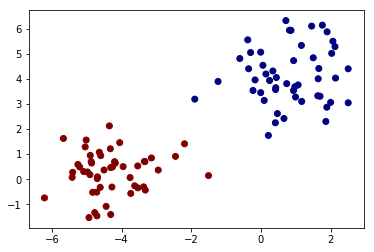

In [3]:
plt.scatter(X[:,0], X[:,1], c=y, cmap = 'jet')

In [4]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

---

In [5]:
def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)

In [6]:
X = add_intercept(X)

In [7]:
def hinge_loss(X_i, y_i, weights):
    loss = 1 - y_i * np.dot(weights.T, X_i)
    if loss < 0:
        loss = 0
    return loss

In [8]:
w = np.zeros(len(X[0]))

In [9]:
loss = []
for i in range(len(X)):
    loss.append(hinge_loss(X[i], y[i], w))
total_loss = np.sum(loss)
total_loss

100.0

In [10]:
w

array([ 0.,  0.,  0.])

In [49]:
# Instead of collecting the average the loss on each row of the dataset, calculate the average loss through each epoch

learning_rate = .01
num_iters = 1000
w = np.zeros(len(X[0]))
# lambda = 1/iteration
loss_list = []
loss_avg_list = []

def Stochastic_Gradient_Descent(X, y, weights, learning_rate, num_iters):
    for iteration in range(1, num_iters):
        loss_list = []
        for row in range(len(X)):
            loss = hinge_loss(X[row], y[row], weights)
            loss_list.append(loss)
            if loss == 0:
                weights = weights - learning_rate * ((2  * (1/iteration) * weights))
            else:
                weights = weights - learning_rate * ((-y[row] * X[row]) + (2  * (1/iteration) * weights))
        loss_avg = np.sum(loss_list) / len(X)
        loss_avg_list.append(loss_avg)
        if iteration % 100 == 0:
            print('Iteration:', iteration, 'average loss:', loss_avg)
    return weights, loss_avg_list
            

In [50]:
weights, loss_avg_list = Stochastic_Gradient_Descent(X = X, y=y, weights = w, learning_rate=.01, num_iters = 1000)

Iteration: 100 average loss: 0.00741490054711
Iteration: 200 average loss: 0.00550091309919
Iteration: 300 average loss: 0.00183107019232
Iteration: 400 average loss: 0.0
Iteration: 500 average loss: 0.000724259932261
Iteration: 600 average loss: 0.000629910319605
Iteration: 700 average loss: 0.0
Iteration: 800 average loss: 0.0
Iteration: 900 average loss: 0.0


In [51]:
weights

array([ 0.32726059, -0.95533768, -0.98592672])

In [52]:
loss = []
for i in range(len(X)):
    loss.append(hinge_loss(X[i], y[i], weights))
total_loss = np.sum(loss)
total_loss

0

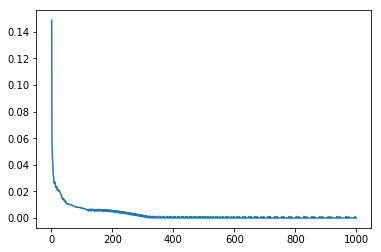

In [56]:
# Convergence of Loss function
plt.plot(range(1, num_iters), loss_avg_list)
#plt.ylim(0,0.02)

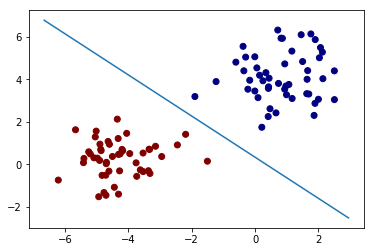

In [53]:
# it works, we've found the perfectly separating hyperplane!
plt.scatter(X[:,1], X[:,2], c=y, cmap = 'jet')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 100)
plt.plot(xx, (-weights[1]/weights[2]) * xx - (weights[0]/weights[2]))

If decide to split this into training and test sets: use this predict function!

In [16]:
def predict(X, weights):
    predictions = np.array([])
    for i in range(len(X)):
        dist_from_hyp = np.dot(X[i], weights)
        if dist_from_hyp > 0:
            predictions = np.append(predictions, 1)
        else:
            predictions = np.append(predictions, -1)
    return predictions

In [16]:
#preds = predict(X_test, weights)
#print(classification_report(y, preds))

### Now testing Sklearn's SCGClassifier on Blob data

In [24]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", alpha=.1, penalty="l2", fit_intercept=True, max_iter=1000)
clf.fit(X, y)

SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [25]:
clf.coef_

array([[ 0.00809963, -0.46829034, -0.46963892]])

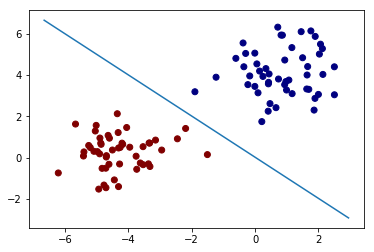

In [26]:
plt.scatter(X[:,1], X[:,2], c=y, cmap = 'jet')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 100)
plt.plot(xx, (-clf.coef_[0,1]/clf.coef_[0,2]) * xx - (clf.coef_[0,0]/clf.coef_[0,2]))

## Now apply Scikit-Learn SVM to Crash data
* Apply [Scikit-Learn's Hinge Loss Metric](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html) as well.
* Instead of their traditional SVM, I could use the [Stochastic Gradient Descent Classifier](http://scikit-learn.org/stable/modules/sgd.html)

```python
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", alpha=0.01, penalty="l2", fit_intercept=True)
clf.fit(X, y)
```

Note that `SVC(kernel="linear")` is equivalent to `SGDClassifier(loss="hinge")` as [scikit-learn's documentation indicates](http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-unbalanced-py)

In [28]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [22]:
X = pd.read_csv('Data/Crash_X2_prepared.csv')
# deleting the dummie columns that double up
X = X.drop(['DRIVER1SEX_F', 'EMRGVEH_No', 'D1COND_Fatigue / Sick', 'MOTORCYCLE_No', 'CRASHSEVER_Property Damage Only' ], axis=1)
y = pd.read_csv('Data/Crash_y2.csv')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [24]:
# Fit the SVM model
clf = SVC(kernel='linear')
clf.fit(X_train, y_train.values.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
clf.coef_

array([[ -6.29920955e-05,  -2.55673019e-05,   5.47977257e-05,
         -3.67141563e-05,   2.43862441e-05,   5.19146302e-05,
         -8.16505670e-04,   9.07554341e-05,   1.17477975e-05,
          1.99982838e+00,  -1.67895171e-04,   1.94747806e-04,
         -1.94747803e-04,   5.04960751e-06,   1.07416327e-04,
          3.72678038e-04]])

In [26]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.86      0.99      0.92     18944
          1       0.89      0.42      0.57      5139

avg / total       0.87      0.86      0.84     24083



In [29]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True negatives:', tn)
print('True positives:', tp)
print('False negatives:', fn)
print('False Positives:', fp)

True negatives: 18679
True positives: 2136
False negatives: 3003
False Positives: 265
